# NNabla Models Finetuning Tutorial

Here we demonstrate how to perform finetuning using nnabla's pre-trained models.

In [ ]:
!pip install nnabla-ext-cuda100
!git clone https://github.com/sony/nnabla.git
%cd nnabla/tutorial


## Load the model

Loading the model is very simple. All you need is just 2 lines.

In [ ]:
from nnabla.models.imagenet import ResNet18
model = ResNet18()

You can choose other ResNet models such as `ResNet34`, `ResNet50`, by specifying the model's name as an argument. Of course, you can choose other pretrained models as well. See the [Docs](https://nnabla.readthedocs.io/en/latest/python/api/models/imagenet.html).

**NOTE**: If you use the `ResNet18` for the first time, nnabla will automatically download the weights from `https://nnabla.org` and it may take up to a few minutes.

## Dataset

In this tutorial, we use [Caltech101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) as the dataset for finetuning.
Caltech101 consists of more than 9,000 object images in total and each image belongs to one of 101 distinct categories or "clutter" category. We use images from 101 categories for simple classification.

We have a script named `caltech101_data.py` which can automatically download the dataset and store it in `nnabla_data`.

If you have your own dataset and `DataIterator` which can load your data, you can use it instead.

In [ ]:
run caltech101_data.py

In [ ]:
batch_size = 32  # we set batch_size = 32
all_data = data_iterator_caltech101(batch_size)

Since there is no separate data for training and validation in caltech101, we need to *manually* split it up.
Here, we will split the dataset as the following way; **80% for training, and 20% for validation.**

In [ ]:
num_samples = all_data.size
num_train_samples = int(0.8 * num_samples)  # Take 80% for training, and the rest for validation. 
num_class = 101
data_iterator_train = all_data.slice(
        rng=None, slice_start=0, slice_end=num_train_samples)
data_iterator_valid = all_data.slice(
        rng=None, slice_start=num_train_samples, slice_end=num_samples)

Now we have model and data!

### Optional: Check the image in the dataset

Let's take a look at what kind of images are included in the dataset. You can get images by `DataIterator`'s method, `next`

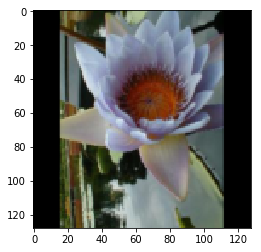

image_shape: (3, 128, 128)
label_id: [94]


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
images, labels = data_iterator_train.next()
sample_image, sample_label = images[0], labels[0]
plt.imshow(sample_image.transpose(1,2,0))
plt.show()
print("image_shape: {}".format(sample_image.shape))
print("label_id: {}".format(sample_label))

### Preparing Graph Construction
Let's start with importing basic modules.

In [ ]:
import nnabla as nn

# Optional: If you want to use GPU
from nnabla.ext_utils import get_extension_context
ctx = get_extension_context("cudnn")
nn.set_default_context(ctx)
ext = nn.ext_utils.import_extension_module("cudnn")

### Create input Variables for the Network

Now we are going to create the input variables.

In [ ]:
channels, image_height, image_width = sample_image.shape  # use info from the image we got

# input variables for the validation network
image_valid = nn.Variable((batch_size, channels, image_height, image_width))
label_valid = nn.Variable((batch_size, 1))
input_image_valid = {"image": image_valid, "label": label_valid}

# input variables for the training network
image_train = nn.Variable((batch_size, channels, image_height, image_width))
label_train = nn.Variable((batch_size, 1))
input_image_train = {"image": image_train, "label": label_train}

### Create the training graph using the pretrained model

If you take a look at the [Model's API Reference](https://nnabla.readthedocs.io/en/latest/python/api/models/imagenet.html), you can find `use_up_to` option. Specifying one of the pre-defined strings when calling the model, the computation graph will be constructed up to the layer you specify. For example, in case of `ResNet18`, you can choose one of the following as the last layer of the graph.

 -  'classifier' (default): The output of the final affine layer for classification.
 -  'pool': The output of the final global average pooling.
 -  'lastconv': The input of the final global average pooling without ReLU activation..
 -  'lastconv+relu': Network up to 'lastconv' followed by ReLU activation.

For finetuning, it is common to replace only the upper layers with the new (not trained) ones and re-use the lower layers with their pretrained weights. Also, pretrained models have been trained on a classification task on ImageNet, which has 1000 categories, so the output of the `classifier` layer has the output shape `(batch_size, 1000)` that wouldn't fit our current dataset. 
For this reason, here we construct the graph up to the `pool` layer, which corresponds to the `global average pooling` layer in the original graph, and connect it to the additional affine (fully-connected) layer for 101-way classification. For finetuning, it is common to train only the weights for the newly added layers (in this case, the last affine layer), but in this tutorial, we will update the weights for *all* layers in the graph. Also, when creating a training graph, you need to set `training=True`.

In [ ]:
import nnabla.parametric_functions as PF

y_train = model(image_train, force_global_pooling=True, use_up_to="pool", training=True)
with nn.parameter_scope("finetuning_fc"):
    pred_train = PF.affine(y_train, 101)  # adding the affine layer to the graph.

**NOTE**: You need to specify `force_global_pooling=True` when the input shape is different from what the model expects. You can check the model's default input shape by typing `model.input_shape`.

### Create the validation graph using the model

Creating the validation graph is almost the same. You simply need to change `training` flag to `False`.

In [ ]:
y_valid = model(image_valid, 
                force_global_pooling=True, use_up_to="pool", training=False)
with nn.parameter_scope("finetuning_fc"):
    pred_valid = PF.affine(y_valid, 101)
pred_valid.persistent = True  # to keep the value when get `forward(clear_buffer=True)`-ed.

### Define the functions for computing Loss and Categorical Error

In [ ]:
import nnabla.functions as F


def loss_function(pred, label):
    """
        Compute loss.
    """
    loss = F.mean(F.softmax_cross_entropy(pred, label))
    return loss

loss_valid = loss_function(pred_valid, label_valid)
top_1_error_valid = F.mean(F.top_n_error(pred_valid, label_valid))
loss_train = loss_function(pred_train, label_train)
top_1_error_train = F.mean(F.top_n_error(pred_train, label_train))

### Prepare the solver

In [ ]:
import nnabla.solvers as S

solver = S.Momentum(0.01)  # you can choose others as well

solver.set_parameters(nn.get_parameters())

### Some setting for iteration

In [ ]:
num_epoch = 10  # arbitrary
one_epoch = data_iterator_train.size // batch_size
max_iter = num_epoch * one_epoch
val_iter = data_iterator_valid.size // batch_size

### Performance before finetuning

Let's see how *well* the model works. Note that all the weights are pretrained on ImageNet except for the last affine layer.
First, prepare a function to show us the model's performance,

In [ ]:
def run_validation(pred_valid, loss_valid, top_1_error_valid,
                   input_image_valid, data_iterator_valid, 
                   with_visualized=False, num_visualized=3):
    assert num_visualized < pred_valid.shape[0], "too many images to plot."
    val_iter = data_iterator_valid.size // pred_valid.shape[0]
    ve = 0.
    vloss = 0.
    for j in range(val_iter):
        v_image, v_label = data_iterator_valid.next()
        input_image_valid["image"].d = v_image
        input_image_valid["label"].d = v_label
        nn.forward_all([loss_valid, top_1_error_valid], clear_no_need_grad=True)
        vloss += loss_valid.d.copy()
        ve += top_1_error_valid.d.copy()

    vloss /= val_iter
    ve /= val_iter
    
    if with_visualized:
        ind = 1
        random_start = np.random.randint(pred_valid.shape[0] - num_visualized)
        fig = plt.figure(figsize=(12., 12.))
        for n in range(random_start, random_start + num_visualized):
            sample_image, sample_label = v_image[n], v_label[n]
            ax = fig.add_subplot(1, num_visualized, ind)
            ax.imshow(sample_image.transpose(1,2,0))
            with nn.auto_forward():
                predicted_id = np.argmax(F.softmax(pred_valid)[n].d)
            result = "true label_id: {} - predicted as {}".format(str(sample_label[0]), str(predicted_id))
            ax.set_title(result)
            ind += 1
        fig.show()

    return ve, vloss

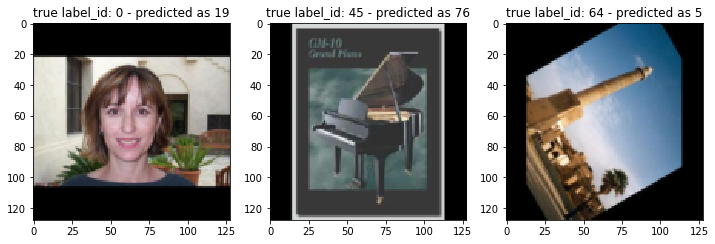

In [14]:
_, _ = run_validation(pred_valid, loss_valid, top_1_error_valid, input_image_valid, data_iterator_valid, with_visualized=True)

As you can see, the model fails to classify images properly. Now, let's begin the finetuning and see how performance improves.

### Start Finetuning

Let's prepare the monitor for training.

In [ ]:
from nnabla.monitor import Monitor, MonitorSeries, MonitorTimeElapsed
monitor = Monitor("tmp.monitor")
monitor_loss = MonitorSeries("Training loss", monitor, interval=200)
monitor_err = MonitorSeries("Training error", monitor, interval=200)
monitor_vloss = MonitorSeries("Test loss", monitor, interval=200)
monitor_verr = MonitorSeries("Test error", monitor, interval=200)

In [16]:
# Training-loop
for i in range(max_iter):
    image, label = data_iterator_train.next()
    input_image_train["image"].d = image
    input_image_train["label"].d = label
    nn.forward_all([loss_train, top_1_error_train], clear_no_need_grad=True)

    monitor_loss.add(i, loss_train.d.copy())
    monitor_err.add(i, top_1_error_train.d.copy())

    solver.zero_grad()
    loss_train.backward(clear_buffer=True)

    # update parameters
    solver.weight_decay(3e-4)
    solver.update()

    if i % 200 == 0:
        ve, vloss = run_validation(pred_valid, loss_valid, top_1_error_valid,
                                   input_image_valid, data_iterator_valid, 
                                   with_visualized=False, num_visualized=3)

        monitor_vloss.add(i, vloss)
        monitor_verr.add(i, ve)

2019-07-05 14:26:26,885 [nnabla][INFO]: iter=199 {Training loss}=1.5021580457687378
2019-07-05 14:26:26,887 [nnabla][INFO]: iter=199 {Training error}=0.3345312476158142
2019-07-05 14:26:28,756 [nnabla][INFO]: iter=200 {Test loss}=2.975713219355654
2019-07-05 14:26:28,756 [nnabla][INFO]: iter=200 {Test error}=0.5384837962962963
2019-07-05 14:26:50,249 [nnabla][INFO]: iter=399 {Training loss}=0.22022955119609833
2019-07-05 14:26:50,250 [nnabla][INFO]: iter=399 {Training error}=0.053437501192092896
2019-07-05 14:26:52,256 [nnabla][INFO]: iter=400 {Test loss}=0.12045302835327608
2019-07-05 14:26:52,257 [nnabla][INFO]: iter=400 {Test error}=0.029513888888888888
2019-07-05 14:27:14,151 [nnabla][INFO]: iter=599 {Training loss}=0.0659928247332573
2019-07-05 14:27:14,152 [nnabla][INFO]: iter=599 {Training error}=0.012500000186264515
2019-07-05 14:27:16,175 [nnabla][INFO]: iter=600 {Test loss}=0.08744175952893717
2019-07-05 14:27:16,175 [nnabla][INFO]: iter=600 {Test error}=0.02199074074074074
2

As you see, the loss and error rate is decreasing as the finetuning progresses.
Let's see the classification result after finetuning.

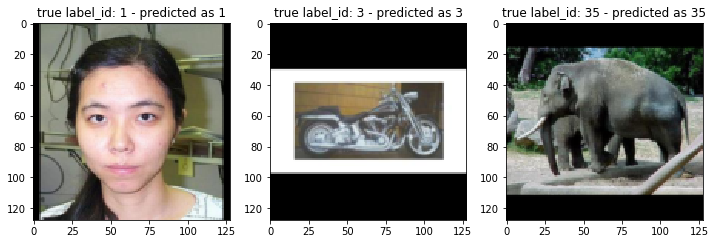

In [17]:
_, _ = run_validation(pred_valid, loss_valid, top_1_error_valid, input_image_valid, data_iterator_valid, with_visualized=True)

You can see now the model is able to classify the image properly.

# Finetuning more

we have a convenient script named `finetuning.py`. By using this, you can try finetuning with different models **even on your original dataset**.

To do this, you need to prepare your own dataset and do some preprocessing. We will explain how to do this in the following.

## Prepare your dataset

Suppose you have a lot of images which can be used for image classification. You need to organize your data in a certain manner. Here, we will explain that with another dataset, [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/). 
First, visit the official page and download `images.tar` (here is the [direct link](http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar)). Next, untar the archive and then you will see a directory named `Images`. Inside that directory, there are many subdirectories and each subdirectory stores images which belong to 1 category. For example, a directory `n02099712-Labrador_retriever` contains labrador retriever's images only. So if you want to use your own dataset, you need to organize your images and directiories in the same way like the following;

```
parent_directory  
├── subdirectory_for_category_A  
│   ├── image_0.jpg  
│   ├── image_1.jpg  
│   ├── image_2.jpg  
│   ├── ...  
│  
├── subdirectory_for_category_B  
│   ├── image_0.jpg  
│   ├── ...  
│  
├── subdirectory_for_category_C  
│   ├── image_0.jpg  
│   ├── ...  
│  
├── subdirectory_for_category_D  
│   ├── image_0.jpg  
│   ├── ...  
│  
 ...
```

The numbers of images in each category can vary, do not have to be exactly the same. Once you arrange your dataset, now you're good to go!


## Create image classification dataset using NNabla CLI

Now that you prepare and organize your dataset, the only thing you have to do is to create a `.csv` file which will be used in `finetuning.py`. To do so, you can use NNabla's [Python Command Line Interface](https://nnabla.readthedocs.io/en/latest/python/command_line_interface.html#create-image-classification-dataset). Just type like the following. 

```
nnabla_cli create_image_classification_dataset -i <path to parent directory> -o <output directory which contains "preprocessed" images> -c <number of channels> -w <width> -g <height> -m <padding or trimming> -s <whether apply shuffle or not> -f1 <name of the output csv file for training data> -f2 <name of the output csv file for test data> -r2 <ratio(%) of test data to training data>
```

If you do that on Stanford Dogs Dataset, 

```
nnabla_cli create_image_classification_dataset -i Images -o arranged_images -c 3 -w 128 -g 128 -m padding -s true -f1 stanford_dog_train.csv -f2 stanford_dog_test.csv -r2 20
```

Note that output `.csv` file will be stored in the same directory you specified with -o option. For more information, please check the [docs](https://nnabla.readthedocs.io/en/latest/python/command_line_interface.html#create-image-classification-dataset).

After executing the command above, you can start finetuning on your dataset. 

## Run finetuning

All you need is just to type one line.

```
python finetuning.py --model <model name> --train-csv <.csv file containing training data>  --test-csv <.csv file containing test data>
```

It will execute finetuning on your dataset!

In [ ]:
run finetuning.py --model ResNet34 --epoch 10 --train-csv ~/nnabla_data/stanford_dog_arranged/stanford_dog_train.csv --test-csv ~/nnabla_data/stanford_dog_arranged/stanford_dog_test.csv --shuffle True

## An example of how to use finetuning's result for inference

Once the finetuning finished, let's use it for inference! The script above has saved the parameters at every certain iteration you specified. So now call the same model you trained and this time let's use the finetuned parameters in the following way.

In [ ]:
from nnabla.models.imagenet import ResNet34
import nnabla as nn

param_path = "params_XXX.h5"  # specify the path to the saved parameter (.h5)

model = ResNet34()
batch_size = 1  # just for inference
input_shape = (batch_size, ) + model.input_shape

Then define an input Variable and a network for inference. Note that you need to construct the network exactly the same way as done in finetuning script (layer configuration, parameters names, and so on...).

In [ ]:
x = nn.Variable(input_shape)  # input Variable
pooled = model(x, use_up_to="pool", training=False)
with nn.parameter_scope("finetuning"):
    with nn.parameter_scope("last_fc"):
        pred = PF.affine(pooled, 120)

Load the parameters which you finetuned above. You can use `nn.load_parameters()` to load the parameters. Once you call this, the parameters stored in the `params.h5` will be stored in global scope. You can check the parameters are different before and after `nn.load_parameters()` by using `nn.get_parameters()`.

In [ ]:
nn.load_parameters(param_path)  # load the finetuned parameters.
pred.forward()